# <u>Exploring [EMBER](https://arxiv.org/abs/1804.04637) dataset</u>
**This is an assignment that was made as part of Cyber AI course led by Dr Yoni Birman, in Reichman university**<br>

Partners resolving the assignments:
 - Gil Zeevi
 - Alon Hartanu
 - Joel Liurner

In [37]:
#importing ember package
import ember
#the 'must' packages
import os
import numpy as np
import pandas as pd
 #visualisation
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (8,6)
#word cloud for EDA
from wordcloud import WordCloud, STOPWORDS
#Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
# Dim reduction methods
import umap
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#ML models
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import sklearn.ensemble as ske
#hyperparameteres tuning
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV

### Creating the data

In [ ]:
ember.create_vectorized_features("data/ember2018/")
ember.create_metadata("data/ember2018/")

### Loading the data

In [11]:
%%time
X_train, y_train, X_test, y_test = ember.read_vectorized_features("data/ember2018/")
emberdf = ember.read_metadata("data/ember2018/")
emberdf

Wall time: 1.36 s


,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,NaN,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,NaN,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,NaN,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,NaN,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,NaN,train
...,...,...,...,...,...
999995,e033bc4967ce64bbb5cafdb234372099395185a6e0280c...,2018-12,1,zbot,test
999996,c7d16736fd905f5fbe4530670b1fe787eb12ee86536380...,2018-12,1,flystudio,test
999997,0020077cb673729209d88b603bddf56b925b18e682892a...,2018-12,0,NaN,test
999998,1b7e7c8febabf70d1c17fe3c7abf80f33003581c380f28...,2018-12,0,NaN,test


# Performing EDA on the vectorized data

In [3]:
def describe_metadata(meta_df):
    print("** Metadata Description **\n")
    # apply sampling to the metadata in order to only load a specific fraction of the files
    # create a list for each of the types of files and split metadata into their respective lists
    malicious_train = meta_df[(meta_df['label'] == 1) & (meta_df['subset'] == 'train')]
    benign_train = meta_df[(meta_df['label'] == 0) & (meta_df['subset'] == 'train')]
    unlabeled_train = meta_df[(meta_df['label'] == -1) & (meta_df['subset'] == 'train')]
    print("Number of Malicious Files in Train Subset: {}".format(len(malicious_train)))
    print("Number of Benign Files in Train Subset: {}".format(len(benign_train)))
    print("Number of Unlabeled Files in Train Subset: {}\n".format(len(unlabeled_train)))

    malicious_test = meta_df[(meta_df['label'] == 1) & (meta_df['subset'] == 'test')]
    benign_test = meta_df[(meta_df['label'] == 0) & (meta_df['subset'] == 'test')]
    unlabeled_test = meta_df[(meta_df['label'] == -1) & (meta_df['subset'] == 'test')]
    print("Number of Malicious Files in Test Subset: {}".format(len(malicious_test)))
    print("Number of Benign Files in Test Subset: {}".format(len(benign_test)))
    print("Number of Unlabeled Files in Test Subset: {}\n".format(len(unlabeled_test)))

    # show the ratio of types of files compared to the overall number of files
    mal_split_train = len(malicious_train) / len(meta_df)
    ben_split_train = len(benign_train) / len(meta_df)
    unlab_split_train = len(unlabeled_train) / len(meta_df)
    print("Malicious File Ratio: {}".format(mal_split_train))
    print("Benign File Ratio: {}".format(ben_split_train))
    print("Unlabeled File Ratio: {}\n".format(unlab_split_train))

    # show the ratio of types of files compared to the overall number of files
    mal_split_test = len(malicious_test) / len(meta_df)
    ben_split_test = len(benign_test) / len(meta_df)
    unlab_split_test = len(unlabeled_test) / len(meta_df)
    print("Malicious File Ratio: {}".format(mal_split_test))
    print("Benign File Ratio: {}".format(ben_split_test))
    print("Unlabeled File Ratio: {}\n".format(unlab_split_test))

In [4]:
describe_metadata(emberdf)

** Metadata Description **

Number of Malicious Files in Train Subset: 300000
Number of Benign Files in Train Subset: 300000
Number of Unlabeled Files in Train Subset: 200000

Number of Malicious Files in Test Subset: 100000
Number of Benign Files in Test Subset: 100000
Number of Unlabeled Files in Test Subset: 0

Malicious File Ratio: 0.3
Benign File Ratio: 0.3
Unlabeled File Ratio: 0.2

Malicious File Ratio: 0.1
Benign File Ratio: 0.1
Unlabeled File Ratio: 0.0



In [53]:
print(f'Minimum Value in Training data: {X_train.min()}\nMaximum Value in Training data: {X_train.max()}\nMean Value in Training data: {X_train.mean()}\nStandard deviation in Training data: {X_train.std()}\n')

Minimum Value in Training data: -4278190080.0
Maximum Value in Training data: 4294967296.0
Mean Value in Training data: 575050.5
Standard deviation in Training data: 29738054.0



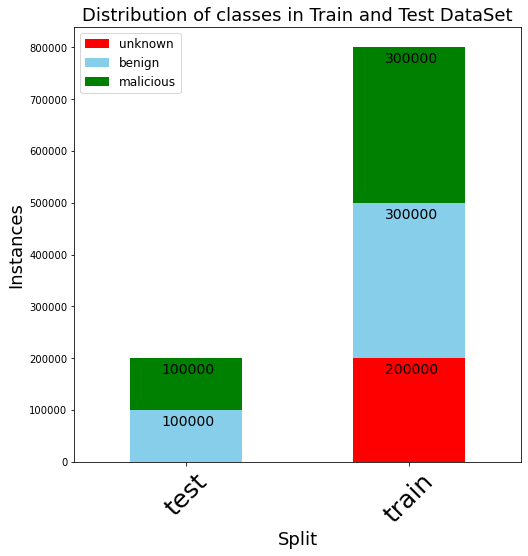

In [6]:
stack = emberdf.pivot_table(index='subset', columns='label',values='appeared',aggfunc='count')
stack.columns = ['unknown','benign','malicious']
ax = stack.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'],figsize=(8,8))
for i in range(2):
    s= 0
    for j in range(3):
        if i==0 and j==0:
            continue
        s+=stack.iloc[i,j]
        ax.annotate(int(stack.iloc[i,j]), (i-0.11,s-30000),fontsize= 14)

plt.xlabel('Split',fontsize= 18)
plt.ylabel('Instances',fontsize= 18)
plt.rc('xtick',labelsize=25)
plt.xticks(rotation=45)
plt.title('Distribution of classes in Train and Test DataSet',fontsize= 18)
plt.legend(fontsize=12)
plt.show()

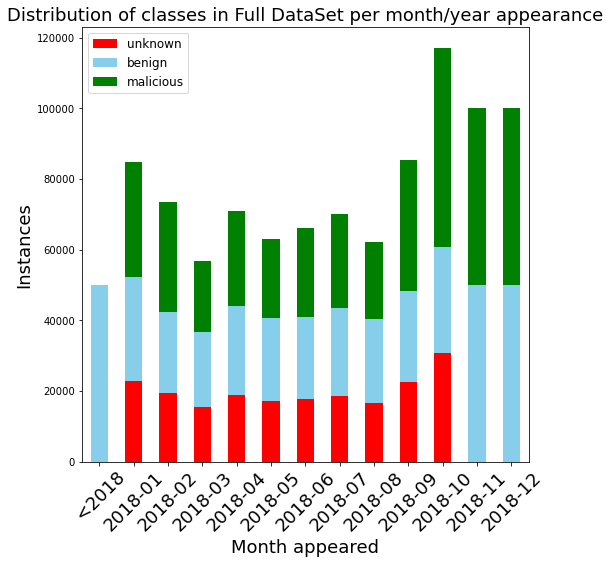

In [9]:
stack = emberdf.copy()
stack.loc[stack["appeared"] < "2018-01", "appeared"] = " <2018"
stack = stack.pivot_table(index='appeared', columns='label',values='sha256',aggfunc='count')
stack.columns = ['unknown','benign','malicious']
ax = stack.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'],figsize=(8,8))
plt.xlabel('Month appeared',fontsize= 18)
plt.ylabel('Instances',fontsize= 18)
plt.rc('xtick',labelsize=18)
plt.xticks(rotation=45)
plt.title('Distribution of classes in Full DataSet per month/year appearance',fontsize= 18)
plt.legend(fontsize=12)
plt.show()

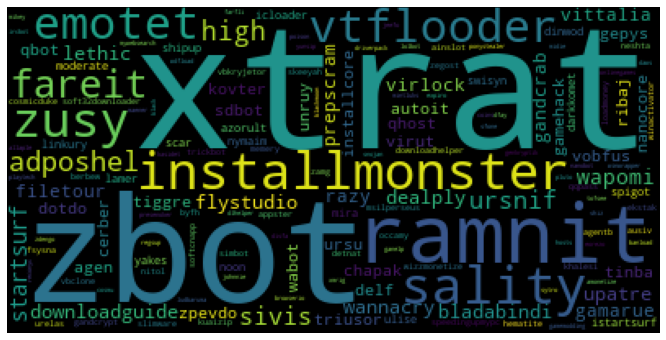

In [10]:
tex = emberdf['avclass'][emberdf['avclass'].notna()].values 
plt.figure(figsize=(15,6))
text = " ".join(title for title in tex)
wordcloud = WordCloud(collocations = False, background_color = 'black').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

AVClass is Python tool to tag / label malware samples. there are 2732 labels


In [11]:
emberdf[emberdf.subset =='train'][emberdf[emberdf.subset =='train'].label == 1].avclass.unique().shape[0]

2732

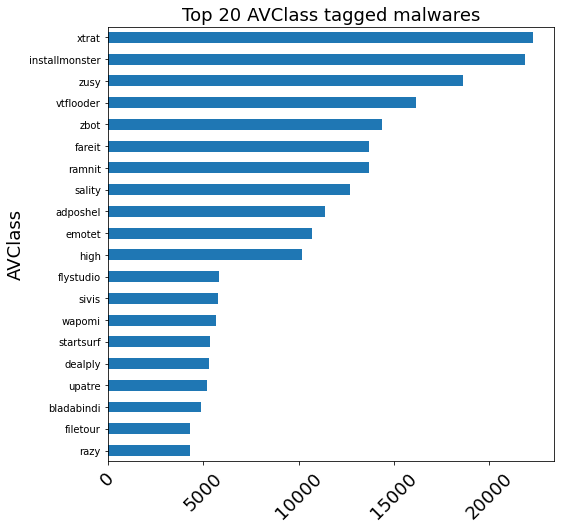

In [12]:
# malicious classification via AVClass
n = 20 #top N tagged malwares
a,b = np.unique(emberdf[emberdf.subset=='train'].avclass.dropna().values,return_counts = True)
d = {}
for i,j in zip(a,b):
    d[i] = j
mal_clus = pd.Series(d)
mal_clus.nlargest(n).sort_values(ascending=True).plot(kind='barh',figsize=(8,8))
plt.ylabel('AVClass',fontsize= 18)
plt.rc('ytick',labelsize=22)
plt.xticks(rotation=45)
plt.title(f'Top {n} AVClass tagged malwares',fontsize= 18)
plt.show()

---

# Data preparation

**unknown labels removal**

In [12]:
%%time
#train
X = X_train[y_train > -1]
y = y_train[y_train > -1]
y= np.array(y,dtype=np.int32)
#test
Xtst = np.array(X_test) 
ytst= np.array(y_test,dtype=np.int32)
print(f'Size in train after unknown labels removal: X: {X.shape}, Y: {y.shape}')

Size in train after unknown labels removal: X: (600000, 2381), Y: (600000,)
Wall time: 42.9 s


# Dimensionality Reduction / Features Engineering / Features Selection

In general we would like to state that Feature engineering is one of those hard parts of Data Science that has no universal solution.<br> We will try to tackle EMBER with several methods but there are so many more methods and we cannot anticipate beforehand what is the best one to go.<br><br>
We care about robustness on one hand but on scalable algorithms on the other hand as we are using local,limited resources, machines, as opposed to those who were used building the EMBER dataset.

we first want to inspect two filter methods:

There are Two possible ways to go:
1. <br>
    - Applying MinMaxScaler to features<br>
    - Chi-Square filtering method
<br>
2.<br> 
    - Estimate mutual information 
**After feature reduction applied, most important features can be found by using decision tree/XGBOOST/lightGBM**

In [52]:
print(f'Minimum Value in Training data: {X.min()}\nMaximum Value in Training data: {X.max()}\nMean Value in Training data: {X.mean()}\nStandard deviation in Training data: {X.std()}\n')

Minimum Value in Training data: -4278190080.0
Maximum Value in Training data: 4294967296.0
Mean Value in Training data: 574316.9375
Standard deviation in Training data: 29699554.0



Okay, this data varies alot, and need to be scaled. the question is how

**applying first filter method - chi square:**<br>
for chi square, MINMAX scaling has to be made because it bounds the transformed features by [0,1].<br>
Pearson's chi square test (goodness of fit) does not apply to negative values. It's logical because the chi square test assumes frequencies distribution and a frequency can't be a negative number. So minmax has to be applied in order to use chi square filter

In [ ]:
# scaling first:
#minmax
X=MinMaxScaler().fit_transform(X)
Xtest=MinMaxScaler().fit_transform(Xtst)

In [ ]:
%%time
SKB = SelectKBest(score_func=chi2, k=500)

fit = SKB.fit(Xt, y)
Xt=SKB.fit_transform(Xt, y)
#---
fit = SKB.fit(Xtest, ytst)
Xtest=SKB.fit_transform(Xtest, ytst)

By, playing with this filtering and applying to different models, we found that this methods didnt fit for the EMBER data due to its need of positive values matrix. applying MinMaxScaler causes to lose essential information in the encoded features or the chi square selection isnt right for this raw data.

**applying a different filter method - mutual selection:**

In [ ]:
%%time
SKB = SelectKBest(score_func=mutual_info_classif, k=500)
fit = SKB.fit(X, y)
Xh=SKB.fit_transform(X, y)
fitb = SKB.fit(Xtst, ytst)
XhTs=SKB.fit_transform(Xtst)#unsupervised
# best_five  = SelectKBest(mutual_info_classif, k=5)
# best_five.fit(X_train, y_train)
# X_train.columns[best_five.get_support()]

This method scale awfuly for this size of database. it should act as first stage filter before applying more complex methods and should remove the less explained features, but considering the time it took to run this method we decided to give up on it and go straightly to PCA

### Applying pca

firstly, we scaling the data with standard scaler which is probably more adequate.It arranges the data in a standard normal<br> distribution which in general is allowed due to *central limit theorem*.

In [16]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X)
# Apply transform to both the training set and the test set.
train = scaler.transform(X)
test = scaler.transform(Xtst)

**Applying pca which captures 95% of the features variance**

In [17]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95) # 95% of the variance.

In [18]:
%%time
pca.fit(train)

Wall time: 2min 30s


PCA(n_components=0.95)

Lets see how many features do we need in order to describe 95% of the features variance

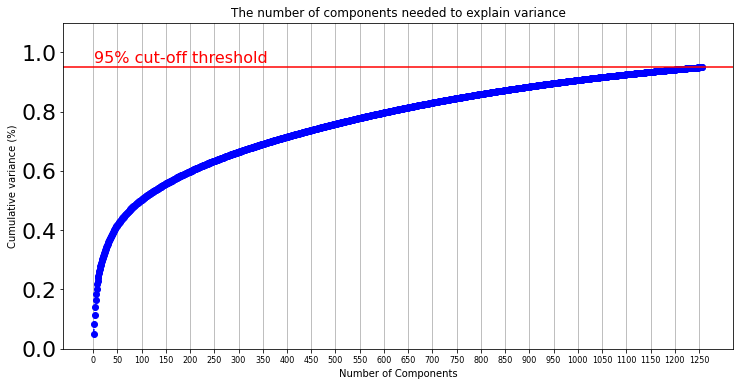

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 1258, step=1)
ytag = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, ytag, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 1300, step=50),fontsize=8)
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.8, 0.965, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Now lets try different approach and reduce to a dimension of 50. if T-sne is desired for a high dimensions database, it is first<br>
recommended to reduce the features to a dimension of 50 and then applying tsne, as a rule of thumb of course, <br>but not as a scientific well established claim.<br>


In [ ]:
%%time
# Apply transform to both the training set and the test set.
pca2 = PCA(n_components=2)
pca2.fit(train)
train = scaler.transform(X)
test = scaler.transform(Xtst)
pca_50 = PCA(50) # reduce to dimension of 50
pca_50.fit(train)
train_50 = pca_50.transform(train)
np.save('train_50.npy', train_50)
test_50 = pca_50.transform(test)
np.save('test_50.npy', test_50)

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca2 = PCA(n_components=2) # 95% of the variance.

In [ ]:
ax = sns.scatterplot(x=test_2[:,0], y=test_2[:,1], hue=ytst, legend='full')
l = ax.legend()
l.get_texts()[0].set_text('Benign')
l.get_texts()[1].set_text('Malicious')
plt.title('t-SNE spread of reduced dimensions EMBER TRAINING Dataset',fontsize=16)
plt.show()

**we see that we need only half of the original components**

In [37]:
%%time
train_95 = pca.transform(train)
np.save('train_95.npy', train_95)
print('finished train_95')
test_95 = pca.transform(test)
np.save('test_95.npy', test_95)
print('finished test_95')

finished train_95
finished test_95
Wall time: 27.7 s


Lets try with reducing to only 50 components and see what happens

In [ ]:
%%time
# Apply transform to both the training set and the test set.
train = scaler.transform(X)
test = scaler.transform(Xtst)
pca_50 = PCA(50) # reduce to dimension of 50
pca_50.fit(train)
train_50 = pca_50.transform(train)
np.save('train_50.npy', train_50)
test_50 = pca_50.transform(test)
np.save('test_50.npy', test_50)

### Applying TSNE - t-Distributed Stochastic Neighbor Embedding

Firstly, we'll apply t-sne for the pca(50) of the data, meaning the original dataset is compressed into a dimension of 50 features

In [39]:
tsne = TSNE()

Now we reduce the dimension into 2D dimension and see if there is a good linear seperation on the 2nd Dimension

In [ ]:
%%time
X_embedded50 = tsne.fit_transform(train_50)
Xtest_embedded50 = tsne.fit_transform(test_50)

In [20]:
X_embedded50=np.load('X_embedded50.npy')
Xtest_embedded50=np.load('Xtest_embedded50.npy')

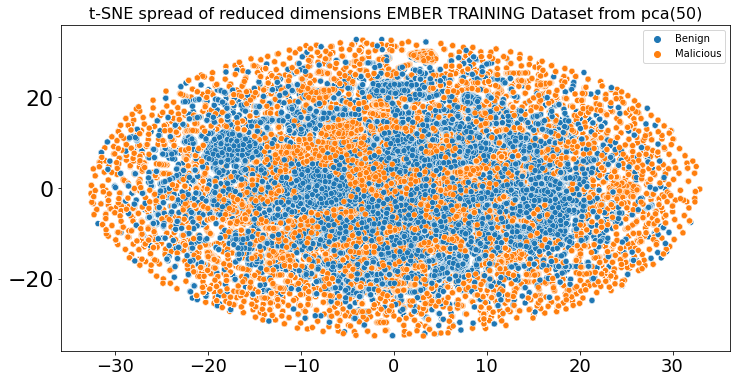

In [43]:
ax = sns.scatterplot(x=X_embedded50[:,0], y=X_embedded50[:,1], hue=y, legend='full')
l = ax.legend()
l.get_texts()[0].set_text('Benign')
l.get_texts()[1].set_text('Malicious')
plt.title('t-SNE spread of reduced dimensions EMBER TRAINING Dataset from pca(50)',fontsize=16)
plt.show()

**Okay, we can probably tell that there is no decisive split in the 2nd reduced dimension.** <br>
lets play some more, then

Now, lets apply t-SNE on the 95% variance maintained - dimentionality reduction data:

In [40]:
%%time
X_embedded95 = tsne.fit_transform(train_95)
Xtest_embedded95 = tsne.fit_transform(test_95)
np.save('X_embedded95.npy',X_embedded95)
np.save('Xtest_embedded95.npy',Xtest_embedded95)
# Wall time: 7h 22min 10s 

Wall time: 7h 22min 10s


Oh boy... that took alot of time. lets see at least if the split is any better:

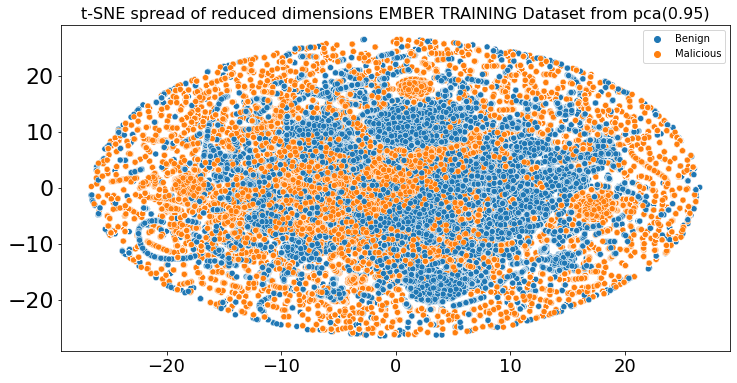

In [45]:
ax = sns.scatterplot(x=X_embedded95[:,0], y=X_embedded95[:,1], hue=y, legend='full')
l = ax.legend()
l.get_texts()[0].set_text('Benign')
l.get_texts()[1].set_text('Malicious')
plt.title('t-SNE spread of reduced dimensions EMBER TRAINING Dataset from pca(0.95)',fontsize=16)
plt.show()

### Applying [UMAP](https://arxiv.org/abs/1802.03426) - Uniform Manifold Approximation and Projection <br>for Dimension Reduction

Lets try a different approach, using UMAP.<br>
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:
<br>
- The data is uniformly distributed on Riemannian manifold;
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.<br>

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.<br>
**([Copied from umap documentation](https://umap-learn.readthedocs.io/en/latest/))**


In [143]:
%%time
fitumap = umap.UMAP()
trainumap = fitumap.fit_transform(X);

C:\Users\Gil zeevi\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Wall time: 10h 58min 36s


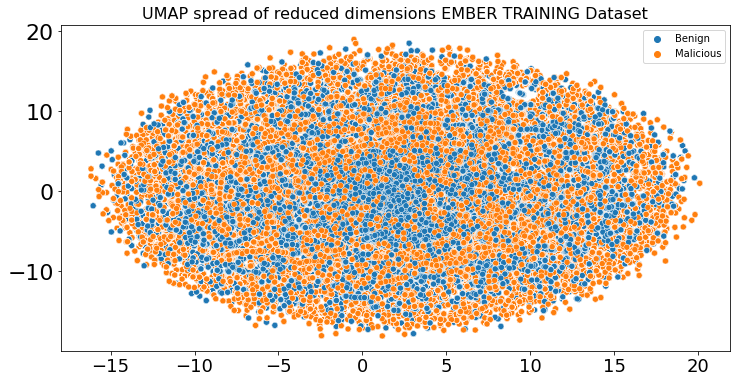

In [144]:
ax = sns.scatterplot(x=trainumap[:,0], y=trainumap[:,1], hue=y, legend='full')
l = ax.legend()
l.get_texts()[0].set_text('Benign')
l.get_texts()[1].set_text('Malicious')
plt.title('UMAP spread of reduced dimensions EMBER TRAINING Dataset',fontsize=16)
plt.show()

We see that also with a different algorithm the data is still not separable in the 2D. hence, *we need to go to higher dimension*!

## Feature selection using XGBOOST

A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Feature importance scores can be used for feature selection in scikit-learn.<br>
This is done using the SelectFromModel class that takes a model and can transform a dataset into a subset with selected features.<br>
This class can take a pre-trained model, such as one trained on the entire training dataset. It can then use a threshold to decide which features to select. This threshold is used  to consistently select the same features on the training dataset and the test dataset.<br>
By doing that, we extract the most important features of EMBER and create a lightweight dataset with a minimal number of features on one hand, but still robust on the other hand as well.

In [5]:
train_95 = np.load('train_95.npy')
test_95 = np.load('test_95.npy')

In [7]:
train_95.shape

(600000, 1257)

We will used the reduced data from pca into a variance of 95% which holds 1257 features

We ran the following piece of code in Colab pro notebook, utilizing its GPU, by calculating XGBOOST on gpu thus able to find the most important features pretty quickly.<br>
We're attaching the piece of code which we ran on colab and the colab notebook as well:<br>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1147BoWdkFrKFF0J-s38KE_QYsQdxg5b3?usp=sharing)


In [ ]:
import xgboost
from numpy import sort
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.feature_selection import SelectFromModel
 
model = XGBClassifier(tree_method='gpu_hist')
model.fit(train_95, y)
# make predictions for test data and evaluate
predictions = model.predict(test_95)
accuracy = roc_auc_score(ytst, predictions) 
print("Auc: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds = thresholds[thresholds > 0]
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(model, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X)
  # train model
  selection_model = XGBClassifier(tree_method='gpu_hist')
  selection_model.fit(select_X_train, y)
  # eval model
  select_X_test = selection.transform(Xtst)
  predictions = selection_model.predict(select_X_test)
  accuracy = roc_auc_score(ytst, predictions)
  print("Thresh=%.3f, n=%d, Auc: %.4f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
#after running the first set of iteration, we found that the first 184 features explain the data the best way
#   if select_X_train.shape[1] == 184: 
#     np.save('/content/drive/MyDrive/ember/ember2018/184features_X.npy',select_X_train)
#     np.save('/content/drive/MyDrive/ember/ember2018/184features_Xtst.npy',select_X_test)
#     break

**In the end, we've managed to reduce our dimension into 184 dimensions out of 2381!**

In [8]:
X_184 = np.load('184features_X.npy')
Xtst_184 = np.load('184features_Xtst.npy')

In [9]:
X_184.shape , Xtst_184.shape

((600000, 184), (200000, 184))

In [10]:
print(f'Number of New features: {X_184.shape[1]}\nMinimum Value in New Training data: {X_184.min()}\nMaximum Value in New Training data: {X_184.max()}\nMean Value in New Training data: {X_184.mean()}\nStandard deviation in New Training data: {X_184.std()}\n')

Number of New features: 184
Minimum Value in New Training data: -2414.445556640625
Maximum Value in New Training data: 8227.6240234375
Mean Value in New Training data: 2.466495516273426e-06
Standard deviation in New Training data: 2.548919439315796



---

# Presenting the Baseline - LightGBM

In [54]:

data_dir = "data/ember2018/"
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))

In [55]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
# emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [127]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9964289467999999

Ember Model Performance at 1% FPR:
Threshold: 0.8336
False Positive Rate: 1.000%
False Negative Rate: 3.502%
Detection Rate: 96.498%

Ember Model Performance at 0.1% FPR:
Threshold: 0.9996
False Positive Rate: 0.098%
False Negative Rate: 13.192%
Detection Rate: 86.80799999999999%


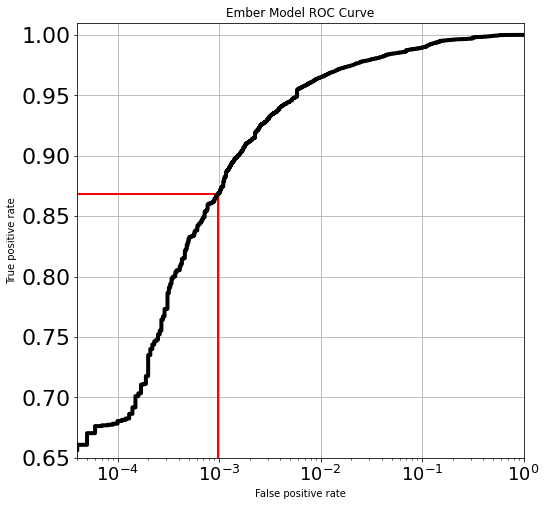

In [128]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

# Clustering the dimentionality reduced data

We can look on the training dataset clustering as a supervised task where we can acquire the clustering using y vector.
we will use supervised algorithms hence we will solve classification problem.

We will inspect two different(Not that different actually) Gradient boosting models.<br>
Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the <br>estimates of a set of simpler, weaker models.
It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.<br>
The following models were inspected
1. LightGBM - *used by EMBER paper*. a gradient boosting framework that uses tree based learning algorithm that is designed to be distributed and efficient with many advantages such as Faster training speed, higher efficiency and Lower memory usage.
<br><br>
2. XGBoost - stands for eXtreme Gradient Boosting and aims to provide a regularizing gradient boosting framework. it aims to provide a "Scalable, Portable and Distributed Gradient Boosting

Both have gained much popularity  as the algorithms of choice for many winning teams of machine learning competitions.
Another reason to use those models ,except their robustness of course, is the ability to train them on GPU which will fasten the training and will make hyperparameters tuning alot faster and more capable.

### <u>LightGBM</u>

Plugging the reduced data with 184 dimension into **LightGBM** without any tunings:

In [20]:
model = LGBMClassifier(objective="binary",device_type='gpu')
model.fit(X_184, y)

LGBMClassifier(device_type='gpu', objective='binary')

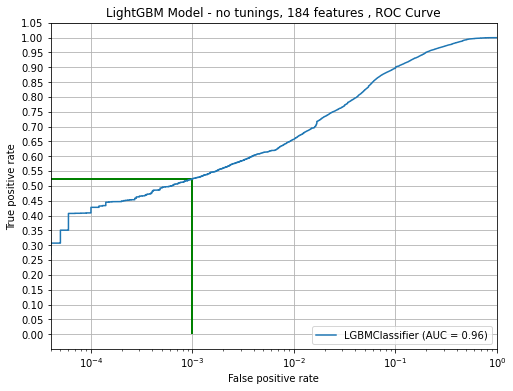

In [27]:
ax = metrics.plot_roc_curve(model,Xtst_184,ytst)
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.vlines(0.001, 0, np.mean(ax.tpr[ax.fpr == 0.001]), color="g", lw=2)
plt.hlines(np.mean(ax.tpr[ax.fpr == 0.001]), 0, 0.001, color="g", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("LightGBM Model - no tunings, 184 features , ROC Curve")
plt.show()

In [31]:
y_pred = model.predict_proba(Xtst_184)
print(f'ROC_AUC Score: {100*roc_auc_score(ytst, y_pred[:, 1]):.3f}%\n')
print("Ember Model Performance at 1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[np.abs(ax.fpr-0.01)<0.0001]) * 100:.3f}%") 
print()
print("Ember Model Performance at 0.1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.001]) * 100:.3f}%")

ROC_AUC Score: 96.460%

Ember Model Performance at 1% FPR:
Detection Rate: 65.769%

Ember Model Performance at 0.1% FPR:
Detection Rate: 52.410%


Performing hyperparameters tuning on the GPU on colab pro notebook:<br>
The following piece of code was executed in colab pro to utilize its GPU capabilities:
the code can be found here as well:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1147BoWdkFrKFF0J-s38KE_QYsQdxg5b3?usp=sharing)

for hp tuning, we used a module called 'Optuna', A hyperparameter optimization framework with somewhat interesting API.

In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [50,100,500]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

	Best parameters chosen are:
		device_type: gpu
		n_estimators: 10000
		learning_rate: 0.2936141158201311
		num_leaves: 180
		max_depth: 8
		min_data_in_leaf: 2100
		lambda_l1: 15
		lambda_l2: 85
		min_gain_to_split: 0.4261257659917306
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.9

**The results after tuning the LightGBM model are as following:**

In [32]:
%%capture
param_grid = {
        "device_type": 'gpu',
        "n_estimators": 10000,
        "learning_rate": 0.2936141158201311,
        "num_leaves": 180,
        "max_depth": 8,
        "min_data_in_leaf": 2100,
        "lambda_l1":15,
        "lambda_l2": 85,
        "min_gain_to_split": 0.4261257659917306,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "feature_fraction":0.9}
modelgbm = LGBMClassifier(objective="binary", **param_grid)
modelgbm .fit(X_184, y)

Text(0.5, 1.0, 'LightGBM Tuned Model, 184 features , ROC Curve')

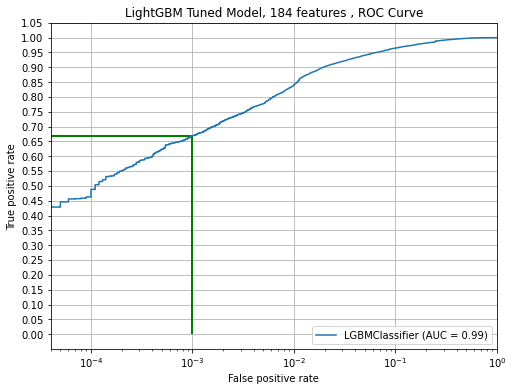

In [33]:
ax = metrics.plot_roc_curve(modelgbm ,Xtst_184,ytst)
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.vlines(0.001, 0, np.mean(ax.tpr[ax.fpr == 0.001]), color="g", lw=2)
plt.hlines(np.mean(ax.tpr[ax.fpr == 0.001]), 0, 0.001, color="g", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("LightGBM Tuned Model, 184 features , ROC Curve")

In [34]:
%%capture
y_pred = modelgbm.predict_proba(Xtst_184)

In [35]:
print(f'ROC_AUC Score: {100*roc_auc_score(ytst, y_pred[:, 1]):.3f}%\n')
print("Ember Model Performance at 1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[np.abs(ax.fpr-0.01)<0.0001]) * 100:.3f}%")
print()
print("Ember Model Performance at 0.1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.001]) * 100:.3f}%")

ROC_AUC Score: 98.686%

Ember Model Performance at 1% FPR:
Detection Rate: 84.033%

Ember Model Performance at 0.1% FPR:
Detection Rate: 66.945%


---

### <u>XGBoost</u>

Plugging the reduced data with 184 dimension into **XGBoost** without any tunings:

In [38]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc',tree_method='gpu_hist')
model.fit(X_184, y)

C:\Users\Gil zeevi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'XGBoost Model - no tunings, 184 features , ROC Curve')

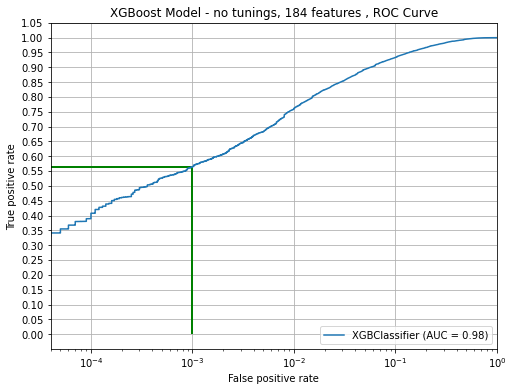

In [39]:
ax = metrics.plot_roc_curve(model,Xtst_184,ytst)
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.vlines(0.001, 0, np.mean(ax.tpr[ax.fpr == 0.001]), color="g", lw=2)
plt.hlines(np.mean(ax.tpr[ax.fpr == 0.001]), 0, 0.001, color="g", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("XGBoost Model - no tunings, 184 features , ROC Curve")

In [40]:
y_pred = model.predict_proba(Xtst_184)
print(f'ROC_AUC Score: {100*roc_auc_score(ytst, y_pred[:, 1]):.3f}%\n')
print("Ember Model Performance at 1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.01]) * 100:.3f}%")
print()
print("Ember Model Performance at 0.1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.001]) * 100:.3f}%")

ROC_AUC Score: 97.652%

Ember Model Performance at 1% FPR:
Detection Rate: 76.129%

Ember Model Performance at 0.1% FPR:
Detection Rate: 56.494%


Performing hyperparameters tuning on the GPU on colab pro notebook:<br>
The following piece of code was executed in colab pro to utilize its GPU capabilities:
the code can be found here as well:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1147BoWdkFrKFF0J-s38KE_QYsQdxg5b3?usp=sharing)

This time we tried a different type of tuning. we tried bayesian grid search.

In [ ]:
#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              'n_estimators': [50,80,100,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.4, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
              }

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
gcvj = int(gcvj)
xgbc0 = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc', use_label_encoder=False,tree_method='gpu_hist')
xgbc0.fit(X , y)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]


#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=gcvj, scoring='roc_auc', cv=3, return_train_score=True, verbose=3)
clf.fit(X_184 , y)

bp = clf.best_params_
bp


    Best parameters chosen are:
        'colsample_bylevel': 0.7999999999999999,
        'colsample_bytree': 0.5,
        'gamma': 0.2,
        'learning_rate': 0.1,
        'max_depth': 8,
        'min_child_weight': 5,
        'n_estimators': 10000,
        'reg_alpha': 0.0,
        'reg_lambda': 0.0,
        'subsample': 0.8999999999999999

In [47]:
param_grid = {
     'colsample_bylevel': 0.7999999999999999,
     'colsample_bytree': 0.5,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 8,
     'min_child_weight': 5,
     'n_estimators': 10000,
     'reg_alpha': 0.0,
     'reg_lambda': 0.0,
     'subsample': 0.8999999999999999
        }
modelxgb = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc',tree_method='gpu_hist',**param_grid)
modelxgb.fit(X_184, y)

C:\Users\Gil zeevi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7999999999999999, colsample_bynode=1,
              colsample_bytree=0.5, enable_categorical=False, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1,
              subsample=0.8999999999999999, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'XGBoost Model - Tuned Model, 184 features , ROC Curve')

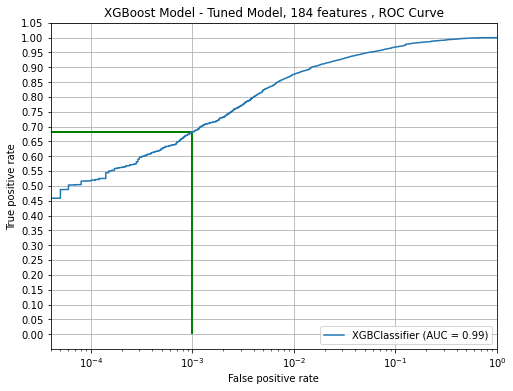

In [48]:
ax = metrics.plot_roc_curve(modelxgb,Xtst_184,ytst)
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.vlines(0.001, 0, np.mean(ax.tpr[ax.fpr == 0.001]), color="g", lw=2)
plt.hlines(np.mean(ax.tpr[ax.fpr == 0.001]), 0, 0.001, color="g", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("XGBoost Model - Tuned Model, 184 features , ROC Curve")

In [49]:
y_pred = modelxgb.predict_proba(Xtst_184)

In [50]:
print(f'ROC_AUC Score: {100*roc_auc_score(ytst, y_pred[:, 1]):.3f}%\n')
print("Ember Model Performance at 1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.01]) * 100:.3f}%")
print()
print("Ember Model Performance at 0.1% FPR:")
print(f"Detection Rate: {np.mean(ax.tpr[ax.fpr == 0.001]) * 100:.3f}%")

ROC_AUC Score: 98.852%

Ember Model Performance at 1% FPR:
Detection Rate: 87.655%

Ember Model Performance at 0.1% FPR:
Detection Rate: 68.194%


# plotting all models:

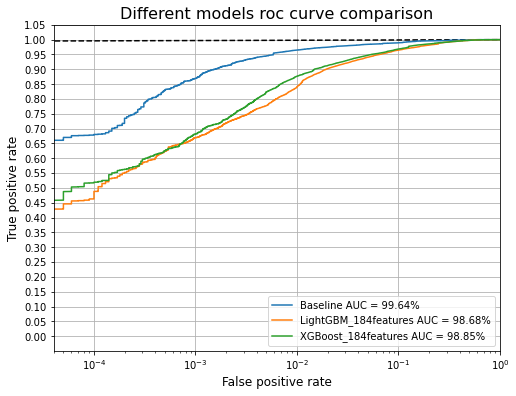

In [63]:
from sklearn.metrics import roc_curve
# y_pred_prob1 = lgbm_model.predict(X_test)
fpr1 , tpr1, thresholds1 = roc_curve(ytst, y_test_pred)

y_pred_prob2 = modelgbm.predict_proba(Xtst_184)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(ytst, y_pred_prob2)


y_pred_prob3 = modelxgb.predict_proba(Xtst_184)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(ytst, y_pred_prob3)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Baseline AUC = 99.64%")
plt.plot(fpr2, tpr2, label= "LightGBM_184features AUC = 98.68%")
plt.plot(fpr3, tpr3, label= "XGBoost_184features AUC = 98.85%")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.title('Different models roc curve comparison',fontsize=16)
plt.legend(loc= 'lower right')
plt.show()

In [102]:
dat=pd.DataFrame(data= [['AUC','99.64%','98.68%','98.85%'],['0.1% FPR Detection','86.8%','66.945%','68.194%'],['1% FPR Detection','96.49%','84.03%','87.65%']],columns =  ['metric','Baseline','LightGBM','XGBoost'])
dat.set_index('metric')

,Baseline,LightGBM,XGBoost
metric,,,
AUC,99.64%,98.68%,98.85%
0.1% FPR Detection,86.8%,66.945%,68.194%
1% FPR Detection,96.49%,84.03%,87.65%


# End of Clustering/ Classification
---

Final thoughts:
- Even though we werent able to surpasss the original model which was trained on 2381 features we were able to present a lightweight dataset(compared to original) with only 184 features which is able to represent the real non reduced data in a manner that one should argue the tradeoff of things.
- our lightweight data is scalable in any local machine compared to the original one which has to be run on monstrous machine due to memory leakage of both RAM and GPU RAM. the accuracy tradeoff is pretty decent all things considered